In [3]:
# Standard libraries
import numpy as np
import h5py
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "mesoscopic-functional-connectivity"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from codes.lib.metrics import graph_lib
from codes.lib.signal_lib import resample
from codes.lib.fc.corr_lib import corr, crossCorr
from codes.lib.data_io.qt_wrapper import gui_fnames, gui_fpath
from codes.lib.data_io.matlab_lib import loadmat
from codes.lib.data_io.yaro.yaro_data_read import read_neuro_perf, read_paw, read_lick, read_whisk
from codes.lib.data_io.yaro.yaro_data_parse_foldernames import parseFoldersMulti
from codes.lib.data_io.yaro.yaro_behaviour_preprocess import resample_lick, resample_paw, resample_whisk

%load_ext autoreload
%autoreload 2

Appended root directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-mesoscopic/mesoscopic-functional-connectivity


# Automatically find subfolders for data and behaviour

In [3]:
tmp_path = root_path_data if 'root_path_data' in locals() else "./"
root_path_data  = gui_fpath("Path to data collection", tmp_path)
root_path_paw   = gui_fpath("Path to Paw data",        root_path_data)
root_path_lick  = gui_fpath("Path to Lick data",       root_path_paw)
root_path_whisk = gui_fpath("Path to Whisk Data",      root_path_lick)

In [4]:
pathDataSets, summary = parseFoldersMulti(root_path_data, root_path_paw, root_path_lick, root_path_whisk)

print("\n\nNumber of day folders for each mouse")
pd.DataFrame(summary)

Searching for channel labels
Searching for data files
Searching for paw files
Searching for lick files
Searching for whisk files


Number of day folders for each mouse


,Data,Paw,Lick,Whisk
mtp_11,12,6,15,11
mtp_7,18,4,23,24
mtp_10,8,11,10,8
mtp_1,9,0,11,11
mtp_12,24,30,20,17
mtp_16,13,0,13,14
mtp_2,8,0,8,10
mtp_15,13,0,13,14
mtp_13,12,8,13,10


# Read available data and behaviour, resample

In [5]:
def pd_filter(data, k, v):
    return data[data[k] == v]

In [6]:
# Read Neuronal data
N_DATA_FILES = pathDataSets['data_path'].shape[0]

dataNeuronal = []
dataTrials   = []
dataPerformance = []

progBar = IntProgress(min=0, max=N_DATA_FILES, description='Read Neuro Data:')
display(progBar) # display the bar
for datapath in pathDataSets['data_path']['path']:
    data, behaviour, performance = read_neuro_perf(datapath, verbose=False)
    dataNeuronal += [data]
    dataTrials   += [behaviour]
    dataPerformance += [performance]
    progBar.value += 1
dataPerformance = np.array(dataPerformance)
    
# Define resampling frequency
TARGET_RANGE = [0, 8] # Seconds goal
TARGET_FREQ = 20 # Hz
TARGET_NTIMES = int((TARGET_RANGE[1]-TARGET_RANGE[0])*TARGET_FREQ) + 1
TARGET_TIMES = np.linspace(TARGET_RANGE[0], TARGET_RANGE[1], TARGET_NTIMES)
print("Target trial within", TARGET_RANGE, "sec. Total target timesteps", TARGET_NTIMES)
    
# # Read and resample paw
# N_PAW_FILES = pathDataSets['paw_path'].shape[0]
# dataPawResampled = []
# progBar = IntProgress(min=0, max=N_PAW_FILES, description='Read paw data:')
# display(progBar) # display the bar
# for pawpath in pathDataSets['paw_path']['path']:
#     dataPaw = read_paw(pawpath, verbose=False)
#     dataPawResampled += [resample_paw(dataPaw, TARGET_TIMES, TARGET_FREQ)]
#     progBar.value += 1

# # Read and resample lick
# N_LICK_FILES = pathDataSets['lick_path'].shape[0]
# dataLickResampled = []
# progBar = IntProgress(min=0, max=N_LICK_FILES, description='Read lick data:')
# display(progBar) # display the bar

# for index, row in pathDataSets['lick_path'].iterrows():
#     # Find behaviour associated with this lick
#     dataIdxs = pd_filter(pathDataSets['data_path'], 'mousekey', row['mousekey']).index
#     if dataIdxs.shape[0] == 0:
#         dataLickResampled += [None]
#     else:
#         dataIdx = dataIdxs[0]
#         neuro = dataNeuronal[dataIdx]
#         behaviour = dataTrials[dataIdx]
#         dataLick = read_lick(row['path'], verbose=False)
#         dataLickResampled += [resample_lick(dataLick, neuro, behaviour, TARGET_TIMES, TARGET_FREQ)]
#     progBar.value += 1

# # Read and resample whisk
# N_WHISK_FILES = pathDataSets['whisk_path'].shape[0]
# progBar = IntProgress(min=0, max=N_WHISK_FILES, description='Read whisk data:')
# display(progBar) # display the bar
# dataWhiskResampled = []
# for whiskpath in pathDataSets['whisk_path']['path']:
#     dataWhisk = read_whisk(whiskpath, verbose=False)
#     dataWhiskResampled += [resample_whisk(dataWhisk, TARGET_TIMES)]
#     progBar.value += 1

IntProgress(value=0, description='Read Neuro Data:', max=117)

Behaviour has more trials than data 438 437
Behaviour max index must be less than number of trials 437 437
Target trial within [0, 8] sec. Total target timesteps 161


# Analysis

## Performance

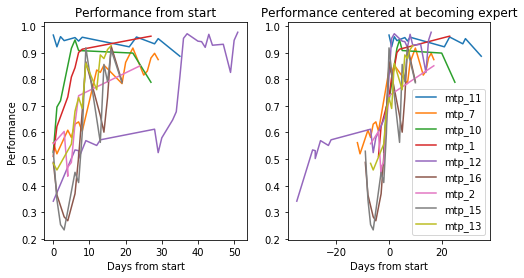

In [7]:
mice = list(set(pathDataSets['channel_labels']['mousename']))
dateDiff = lambda l: np.array([(v - l.iloc[0]).days for v in l])

deltaDays         = np.zeros(N_DATA_FILES)
deltaDaysCentered = np.zeros(N_DATA_FILES)

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for mousename in mice:
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:        
        dataIdxs = np.array(mouseData["date"].index)
        
        perf = dataPerformance[dataIdxs]
        expertIdx = np.where(perf > 0.7)[0][0]
        
        deltaDays[dataIdxs] = dateDiff(mouseData["date"])
        deltaDaysCentered[dataIdxs] = deltaDays[dataIdxs] - deltaDays[dataIdxs][expertIdx]

            
        ax[0].plot(deltaDays[dataIdxs], perf, label=mousename)
        ax[1].plot(deltaDaysCentered[dataIdxs], perf, label=mousename)

ax[0].set_title("Performance from start")
ax[1].set_title("Performance centered at becoming expert")
ax[0].set_xlabel("Days from start")
ax[1].set_xlabel("Days from start")
ax[0].set_ylabel("Performance")
plt.legend()
plt.show()

## Pure data-based
1. Activity vs Learning
  * Variance of one channel over time (incl days)
  * Variance across mice

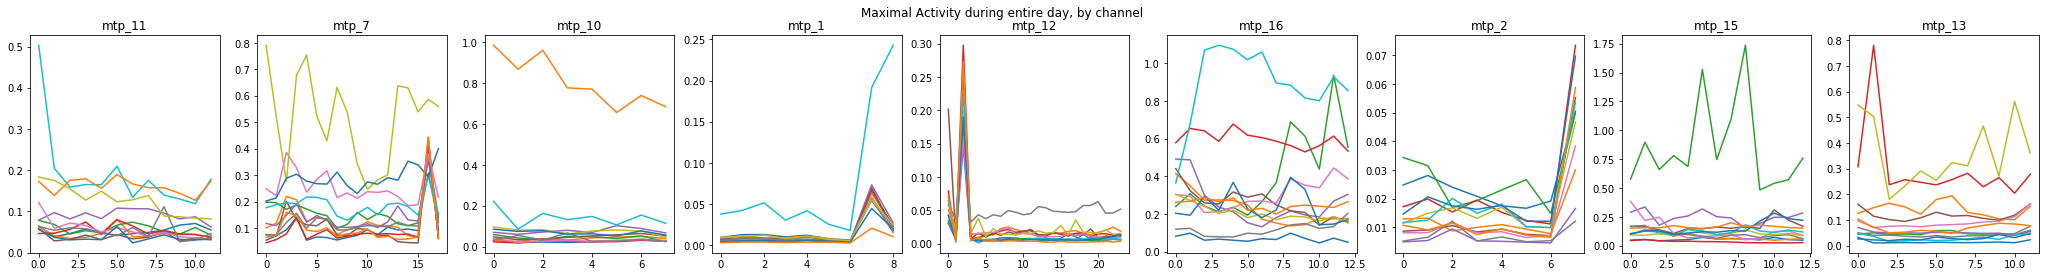

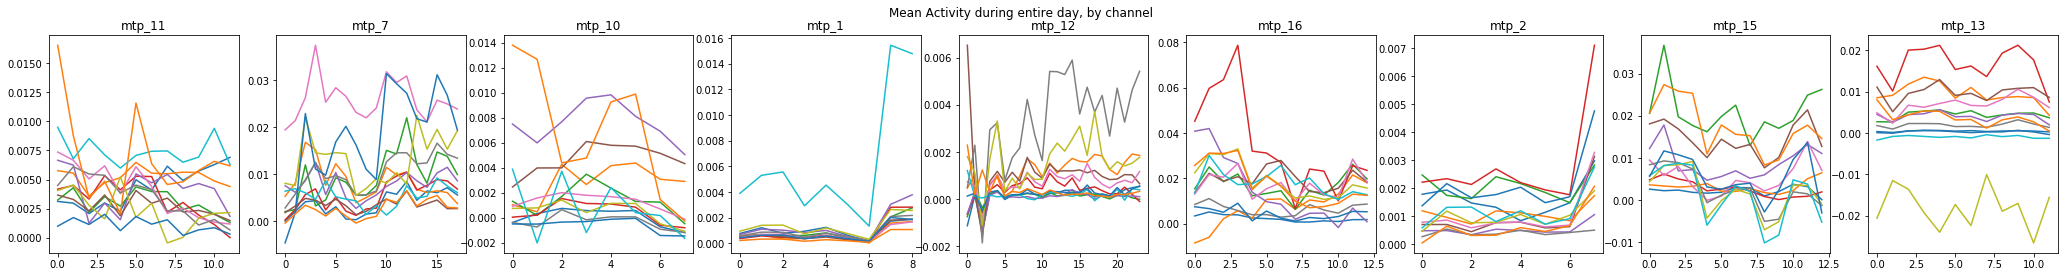

In [8]:
nPlot = len(mice)
fig1, ax1 = plt.subplots(ncols=nPlot, figsize=(nPlot*4, 4))
fig2, ax2 = plt.subplots(ncols=nPlot, figsize=(nPlot*4, 4))
fig1.suptitle("Maximal Activity during entire day, by channel")
fig2.suptitle("Mean Activity during entire day, by channel")

for iPlot, mousename in enumerate(mice):
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:
        dataIdxs = list(mouseData["date"].index)
        nDays = len(dataIdxs)
        
        channelMax = np.zeros((len(dataIdxs), 12))
        channelMean = np.zeros((len(dataIdxs), 12))
        for i, dataIdx in enumerate(dataIdxs):
            dataThis = dataNeuronal[dataIdx]
            channelMax[i] = np.max(dataThis, axis=(0,1))
            channelMean[i] = np.mean(dataThis, axis=(0,1))
            
        ax1[iPlot].set_title(mousename)
        ax2[iPlot].set_title(mousename)
        ax1[iPlot].plot(channelMax)
        ax2[iPlot].plot(channelMean)
plt.show()

## 1. Correlation and Synchrony

**THINGS TO TRY**:
1. MI instead of TE
2. Some clustering measure
3. Repeat for other mice

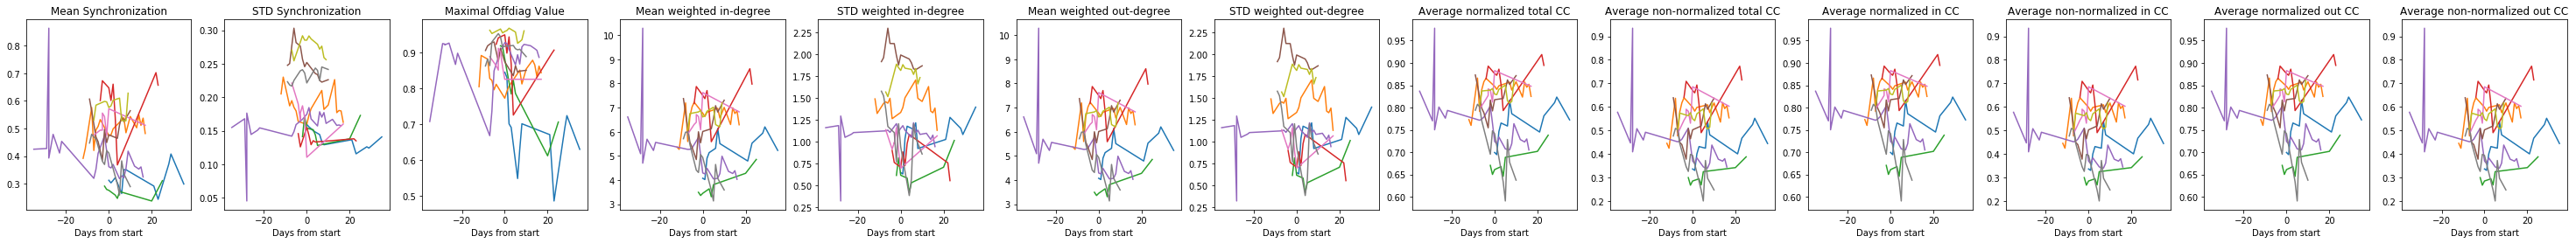

In [9]:
testNames = [
    "Mean Synchronization",
    "STD Synchronization",
    "Maximal Offdiag Value",
    "Mean weighted in-degree",
    "STD weighted in-degree",
    "Mean weighted out-degree",
    "STD weighted out-degree",
    "Average normalized total CC",
    "Average non-normalized total CC",
    "Average normalized in CC",
    "Average non-normalized in CC",
    "Average normalized out CC",
    "Average non-normalized out CC"]
nTest = len(testNames)

fig, ax = plt.subplots(ncols=nTest, figsize=(nTest*4, 4))

for mousename in mice:
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:    
        dataIdxs = list(mouseData["date"].index)
        
        testResults = np.zeros((len(dataIdxs), nTest))
        for i, dataIdx in enumerate(dataIdxs):
            # Compute cross-correlation absolute value
            dataThis = dataNeuronal[dataIdx].transpose(2,1,0) #channel x time x trial for cross-corr
            cAbs = np.abs(crossCorr(dataThis, 0, 0)[0])
            
            # Compute connectivity metrics
            testResults[i] = np.array([
                *graph_lib.diagonal_dominance(cAbs),
                np.max(graph_lib.offdiag(cAbs)),
                np.mean(graph_lib.degree_in(cAbs)),
                np.std(graph_lib.degree_in(cAbs)),
                np.mean(graph_lib.degree_out(cAbs)),
                np.std(graph_lib.degree_out(cAbs)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='tot', normDegree=True)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='tot', normDegree=False)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='in', normDegree=True)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='in', normDegree=False)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='out', normDegree=True)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='out', normDegree=False))
            ])
            
        for iTest in range(nTest):
            ax[iTest].plot(deltaDaysCentered[dataIdxs], testResults[:,iTest], label=mousename)

for iTest in range(nTest):
    ax[iTest].set_title(testNames[iTest])
    ax[iTest].set_xlabel("Days from start")
    #ax[iTest].legend()
plt.show()

## 1.2 Clustering of data

1. For each mouse, for each time, compute corr
2. Compute CC vs time (mean/var)
3. Plot for all mice
4. Then split Go/NoGO

mtp_13
-- mtp_13_2017_03_08_a iGO 116
-- mtp_13_2017_03_09_a iGO 248
-- mtp_13_2017_03_13_a iGO 79
-- mtp_13_2017_03_14_a iGO 332
-- mtp_13_2017_03_15_a iGO 261
-- mtp_13_2017_03_16_a iGO 294
-- mtp_13_2017_03_17_a iGO 404
-- mtp_13_2017_03_20_a iGO 76
-- mtp_13_2017_03_21_a iGO 282
-- mtp_13_2017_03_22_a iGO 280
-- mtp_13_2017_03_23_a iGO 347
-- mtp_13_2017_03_24_a iGO 279
-- mtp_13_2017_03_08_a iNOGO 96
-- mtp_13_2017_03_09_a iNOGO 183
-- mtp_13_2017_03_13_a iNOGO 59
-- mtp_13_2017_03_14_a iNOGO 229
-- mtp_13_2017_03_15_a iNOGO 145
-- mtp_13_2017_03_16_a iNOGO 185
-- mtp_13_2017_03_17_a iNOGO 343
-- mtp_13_2017_03_20_a iNOGO 99
-- mtp_13_2017_03_21_a iNOGO 303
-- mtp_13_2017_03_22_a iNOGO 238
-- mtp_13_2017_03_23_a iNOGO 348
-- mtp_13_2017_03_24_a iNOGO 251


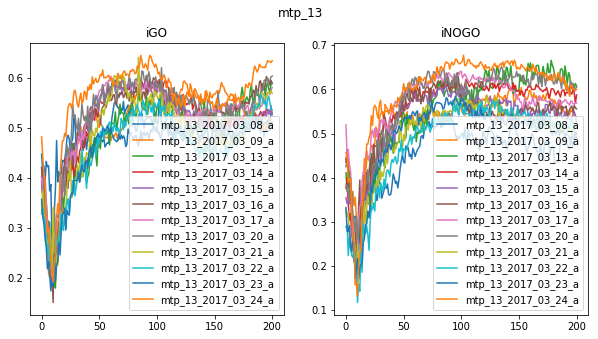

In [41]:
trialKeys = ['iGO', 'iNOGO']
nTrialKeys = len(trialKeys)


for mousename in mice[:1]:
    print(mousename)
    
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:
        dataIdxs = list(mouseData["date"].index)
        
        fig, ax = plt.subplots(ncols=nTrialKeys, figsize=(5*nTrialKeys,5))
        fig.suptitle(mousename)
        
        for iKey, trialKey in enumerate(trialKeys):
            for i, dataIdx in enumerate(dataIdxs):
                
                
                dataLabel = pathDataSets['data_path']['mousekey'][dataIdx]
                trialIdx = dataTrials[dataIdx][trialKey]
                dataThis = dataNeuronal[dataIdx][trialIdx-1]

                print("--", dataLabel, trialKey, len(trialIdx))

                nTrial, nTime, nChannel = dataThis.shape

                ccNoNorm = np.zeros(nTime)
                for iTime in range(nTime):
                    corrAbs = np.abs(corr(dataThis[:, iTime, :].T))
                    ccNoNorm[iTime] = np.mean(graph_lib.cl_coeff(corrAbs, normDegree=False))

                ax[iKey].plot(ccNoNorm, label=dataLabel)

            ax[iKey].set_title(trialKey)
            ax[iKey].legend()
plt.show()